# Importing the Requisite Libraries

In [3]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
import quantstats as qs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Logistic Regression Function

In [10]:
def logistic_regression(train, test):

    # Creating the columns of independent variables as dummy variables
    train['C-L > H-C'] = np.where((train['Close'] - train['Low']) > (train['High'] - train['Close']), 1, 0)
    train['H > Ht-1'] = np.where(train['High'] > train['High'].shift(1), 1, 0)
    train['L > Lt-1'] = np.where(train['Low'] > train['Low'].shift(1), 1, 0)
    train['Ct+1 > C'] = np.where(train['Close'].shift(-1) > train['Close'], 1, 0)

    train = train[1:]

    # Defining the X and Y variable for input in the regression model
    a = train[['C-L > H-C', 'H > Ht-1', 'L > Lt-1']]
    b = train[['Ct+1 > C']]

    # Creating the object and using the fit function to generate the betas
    model = LogisticRegression()
    model.fit(a, b)

    # Defining the same independent variable columns as for the test data set
    test['C-L > H-C'] = np.where((test['Close'] - test['Low']) > (test['High'] - test['Close']), 1, 0)
    test['H > Ht-1'] = np.where(test['High'] > test['High'].shift(1), 1, 0)
    test['L > Lt-1'] = np.where(test['Low'] > test['Low'].shift(1), 1, 0)

    # Creating the Z-value column by doing a sumproduct of the betas and the respective independent variable
    test['Z'] = model.intercept_ + \
                test['C-L > H-C'] * model.coef_[0][0] + \
                test['H > Ht-1'] * model.coef_[0][1] + \
                test['L > Lt-1'] * model.coef_[0][2]

    # Converting the linear Z equation into probability using the sigmoid function
    test['Probability'] = np.exp(test['Z']) / (1 + np.exp(test['Z']))

    test = test[1:]

    # Defining the entry logic
    test['Entry'] = np.where(test['Probability'] > 0.5, test['Close'], 0)

    # Defining the exit logic
    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) < test['Close']),
                             test['Open'].shift(-1), 0)

    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) > test['Close']),
                             test['Close'].shift(-1), test['Exit'])

    # Calculating the P&L on an MTM basis
    test['P&L'] = test['Exit'] - test['Entry']

    # Generating the equity curve of the strategy
    test['Equity curve'] = test['P&L'].cumsum() + int(test['Close'][0])

    # Plotting the equity curve of the strategy against the benchmark
    test[['Equity curve', 'Close']].iloc[:-1].plot()

    return test.iloc[:-1]

# Performance Analysis

---



In [11]:
def performance_analysis(df):
    df['Returns'] = df['Equity curve']/df['Equity curve'].shift(1) - 1
    qs.reports.full(df['Returns'])

# Calling the Respective Functions

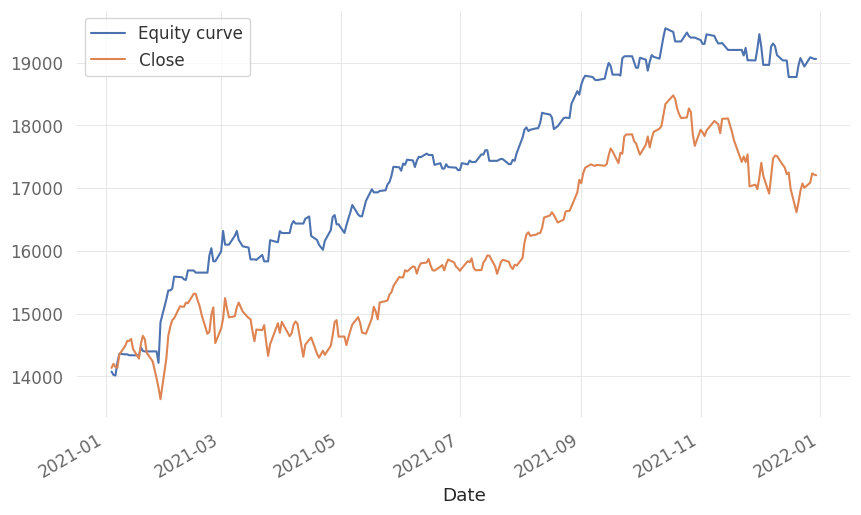

In [12]:
year = 2020

train = pd.read_excel(f'{year}.xlsx', parse_dates=True)
test = pd.read_excel(f'{year+1}.xlsx', parse_dates=True)
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

logistic = logistic_regression(train, test)